<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/ML_T4_gradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from keras import layers
from keras import models
import keras

# gradCAM

## Interpretación informal

Consideremos una sucesión finita de capas convolucionales no necesariamente consecutivas (podría haber capas intermedias)

La última capa convolucional genera outputs que siguen siendo matrices, es decir, elementos de $\mathcal{R}^{u\times v}$.

Nos gustaría definir una transformación diferenciable cuya imagen sea la densidad de probailidad de las clases de clasificación. De hecho, al estar considerando la última capa convolucional, podemos estar seguros que las siguientes capas son de clasificación y por lo tanto son combinaciones lineales de los pesos de sus capas y de las matrices dadas por la última convolucional.


La idea es considerar la derivada de estas densidades (probabilidades de pertenecer a la clase) respecto a las entradas de la matriz generada por la última capa de clasificación. Digamos 
$$\frac{\partial f}{\partial A_{i,j}}$$

Con esta noción en mente, podemos calcular cuánto cambia la decisión (probabilidad) respecto al valor de la última "imagen" ingresada. Más aún, podemos conocer qué entradas de esa "imagen" es la que aporta más al cambio de decisión (por la dirección del gradiente).

## Ejemplo.

Consideremos el problema de clasificación de "Neumonía" "No-Neumonía" basado en imágenes de radiografías, el cual se realizó en la tarea anterior.

Obtenemos imágenes del directorio "test" para visualización del gradCAM.

Nos gustaría obtener un mapa de calor que muestre la zona de la imagen en la cual la red neuronal se fija para hacer la clasificación de Neumonía o No-Neumonía.

Así que consideramos 1 imagen aleatoria de las imágenes de prueba.

In [142]:
from os import listdir

def loadImages(path):
    # return array of images

    imagesList = listdir(path)
    loadedImages = []
    for image in imagesList:
        img = cv2.imread(path + image)
        loadedImages.append(cv2.resize(img,(300,300)))

    return np.array(loadedImages)
test_neumonia= loadImages("/content/drive/MyDrive/test/PNEUMONIA/")

Se define la función que calcula el mapa de calor para una una imagen, dada una capa convolucional, y las últimas capas de clasificación de la red neuronal

In [136]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    
    # Modelo que mapea la imagen de entrada a la capa convolucional última,
    # donde se calculará la activación
    last_conv_layer  = model.get_layer(last_conv_layer_name)
    conv_model       = keras.Model(model.inputs, last_conv_layer.output)

    # Modelo que mapea las activaciones a la salida final
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    
    # Cálculo del gradiente la salida  del modelo clasificador respecto a     
    with tf.GradientTape() as tape:
        
        # Calcula activacion del modelo base convolucional
        last_conv_layer_output = conv_model(img_array)
        tape.watch(last_conv_layer_output)
        
        # Calcula la predicción con modelo clasificador, para la clase mas probable
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        print(top_pred_index)
        top_class_channel = preds[:, top_pred_index]

    # Obtenemos el gradiente en la capa final clasificadora con respecto a
    # la salida del modelo base convolucional
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # Vector de pesos: medias del gradiente por capas,
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # salida de la última capa convolucional
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    
    # saliencia es la respuesta promedio de la última capa convolucional
    saliency = np.mean(last_conv_layer_output, axis=-1)
    saliency = np.maximum(saliency, 0) / np.max(saliency)
    
    # Multiplicación de cada canal por el vector de pesos
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
        
    # Heatmap: promedio de cada canal por su peso
    grad_cam = np.mean(last_conv_layer_output, axis=-1)
    grad_cam = np.maximum(grad_cam, 0) / np.max(grad_cam)
    
    return grad_cam, saliency

En la tarea pasada consideramos transferencia de conocimiento desde la base convolucional de **EfficientNetB3**. Así, llamamos a la base entrenada final que se obtuvo en esa tarea.

In [127]:
from keras.models import load_model
model = load_model('neumonia_full_trained.h5')

In [6]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 1536)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          884800    
                                                                 
 flatten_2 (Flatten)         (None, 576)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               147712    
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                      

Recordemos que en la "base" **efficientnetb3** hay capas convolucionales, sin embargo, consideramos la última convolucional de la red completa, en este caso, "conv2d_2".

De igual manera, notamos que hay 4 capas de clasificación, 3 de ellas densas, las cuales serán los argumentos para calcular las densidades de las predicciones de pertenencia a cada clase.

In [128]:
from skimage.transform import resize
def show_hotmap (img, heatmap, title='Heatmap', alpha=0.4, cmap='jet', axisOnOff='off'):
    '''
    img     :    Image
    heatmap :    2d narray
    '''
    resized_heatmap=resize(heatmap, img.size)
    
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.imshow(resized_heatmap, alpha=alpha, cmap=cmap)
    plt.axis(axisOnOff)
    plt.title(title)
    plt.show()

In [144]:
from PIL import Image
def get_img_array(img, img_size):
    
    img = Image.fromarray(img)
    
    img = img.resize(size=img_size)
    print(f'format: {img.format}, shape: {img.size}, mode: {img.mode}')
    img_array = np.array(img).astype('float32')[:,:,:3]  # tiramos el canal alpha
    img_array = np.expand_dims(img_array, axis=0)
    return img, img_array

format: None, shape: (300, 300), mode: RGB


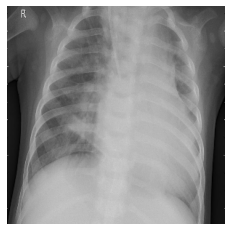

In [166]:
img=test_neumonia[np.random.choice(range(0,len(test_neumonia)),size=1)][0,:,:,:]
img_size = (300, 300)
preprocess_input = keras.applications.xception.preprocess_input
img,img_array =  get_img_array(img = img,    
                               img_size = (300,300))

img_array = img_array/255.
plt.imshow(img)
plt.axis('off')
plt.show()

Calculamos el gradCAM

In [161]:
grad_cam, saliency = make_gradcam_heatmap(img_array, 
                                          model, 
                                          'conv2d_2', 
                                          ['flatten_2','dense_6','dense_7','dense_8'])

tf.Tensor(1, shape=(), dtype=int64)


Se obtiene una matriz con las entradas que más aportan a la clasificación identificadas como un mapa de calor. Notemos que las dimensiones de estas matrices coinciden con las dimensiones del output de la última capa convolucional

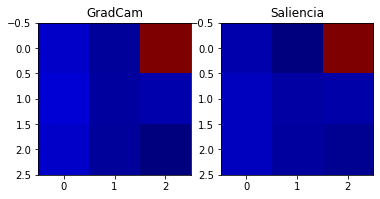

In [162]:
plt.subplot(121)
plt.imshow(grad_cam, 'jet')
plt.title('GradCam')
plt.subplot(122)
plt.imshow(saliency, 'jet')
plt.title('Saliencia')
plt.show()

Para finalizar, graficamos en un mapa de calor la zona correspondiente al gradCAM para una imagen aleatoria de las clasificadas como "Neumonía"

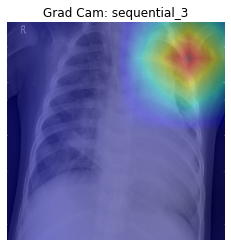

In [167]:
show_hotmap(img=img, heatmap=grad_cam, title=f'Grad Cam: {model.name}')

# Conclusiones

Se presentó una idea muy informal pero intuitiva de lo que se necesita para hacer el gradCAM, una herramienta que te permite entender cómo decide una red neuronal una clasificación considerando imágenes, o más específicamente, zonas de imágenes. Con esto, se puede responder parcialmente a la pregunta "¿Por qué decidió eso?", cuando tenemos una red entrenada.

En este ejemplo, la zona resaltada no es fácilmente interpretable, pues aunque se encuentra cerca, no se concentra en los pulmones, la cual era la característica esperada.

Esto podría deberse a un mal desempeño de la red, la cual, como se mostró en la tarea pasada, se desempeño pobremente ($\sim 80\%$) en la etapa de prueba (en el ejercicio usamos una imagen de prueba), o bien debido a la reducción de dimensiones después de tantas capas convolucionales, pues en este caso, el output es de dimensión $3\times 3$, lo cual haría pobre una identificación de los pesos importantes en la etapa de clasificación.